In [219]:
import numpy as np
import pandas as pd

In [220]:
train = pd.read_csv('../data/train.csv')
gas = pd.read_csv('../data/gas_prices.csv')
electricity = pd.read_csv('../data/electricity_prices.csv')
hw = pd.read_csv('../data/historical_weather.csv')
fw = pd.read_csv('../data/forecast_weather.csv')
wtm = pd.read_csv('../data/weather_station_to_county_mapping.csv')
client = pd.read_csv('../data/client.csv')

## Data featuring

In [221]:
print(np.round(wtm.isna().sum().sum() / (wtm.shape[0] * wtm.shape[1]) * 100, 2), '% of the',
      wtm.shape[0] * wtm.shape[1], 'weather county mapping values are null.')

28.12 % of the 448 weather county mapping values are null.


In [222]:
import math

##On crée une distance pour compléter les long-lat sans county, afin d'utiliser le county pour affiner le groupement sur la météo
wtm['distance'] = wtm['longitude'] + wtm['latitude']
wtm_county = wtm[wtm['county'].isna() == False]

wtm['county'] = wtm.apply(
    lambda x: (wtm_county.iloc[(wtm_county['distance'] - x['distance']).abs().argsort()[:1]])['county'].values[
        0] if math.isnan(x['county']) else x['county'], axis=1)
wtm

,county_name,longitude,latitude,county,distance
0,NaN,21.7,57.6,10.0,79.3
1,NaN,21.7,57.9,10.0,79.6
2,NaN,21.7,58.2,10.0,79.9
3,NaN,21.7,58.5,10.0,80.2
4,NaN,21.7,58.8,10.0,80.5
...,...,...,...,...,...
107,NaN,28.2,58.5,2.0,86.7
108,NaN,28.2,58.8,2.0,87.0
109,NaN,28.2,59.1,2.0,87.3
110,NaN,28.2,59.4,2.0,87.6


#### Historical Weather

In [223]:
hw['distance'] = hw['longitude'] + hw['latitude']

wtm_merge = wtm.drop(columns=['latitude', 'longitude', 'county_name'])
hw = hw.merge(wtm_merge, on='distance', how='left')
hw.drop(columns='distance', inplace=True)

In [224]:
grouped_hweather = hw.groupby(['datetime', 'county']).mean()
merge_temp = grouped_hweather.drop(columns=['data_block_id'])
train = train.merge(merge_temp, how="left", on=["datetime", "county"])

#### Forecast Weather

In [225]:
fw['distance'] = fw['longitude'] + fw['latitude']

wtm_merge = wtm.drop(columns=['latitude', 'longitude', 'county_name'])
fw = fw.merge(wtm_merge, on='distance', how='left')
fw.drop(columns='distance', inplace=True)

In [226]:
grouped_fweather = fw.drop(columns=['origin_datetime'])
grouped_fweather.rename(columns={'forecast_datetime': 'datetime'}, inplace=True)
grouped_fweather = grouped_fweather.groupby(['datetime', 'county']).mean()

merge_fweather = grouped_fweather.drop(columns=['latitude', 'longitude', 'data_block_id'])
merge_fweather.columns = list(map(lambda c: "fc_%s" % c, merge_fweather.columns))

train = train.merge(merge_fweather, how="left", on=["datetime", "county"])

#### Electricity Prices

In [227]:
merge_elec = electricity.filter(items=['euros_per_mwh', 'forecast_date'], axis=1)
merge_elec.rename(columns={"forecast_date": "datetime", "euros_per_mwh": "elec_price"}, inplace=True)

train = train.merge(merge_elec, how="left", on="datetime")

#### Gas Prices

In [228]:
train["forecast_date"] = pd.to_datetime(train["datetime"]).dt.strftime('%Y-%m-%d')

In [229]:
merge_gas = gas.filter(items=['lowest_price_per_mwh', 'highest_price_per_mwh', 'forecast_date'], axis=1)
merge_gas.rename(columns={"lowest_price_per_mwh": "lowest_gas_price", "highest_price_per_mwh": "highest_gas_price"},
                 inplace=True)

train = train.merge(merge_gas, how="left", on="forecast_date")

#### Client

In [230]:
grouped_client = client.drop(columns=['data_block_id', 'is_business'])
grouped_client.rename(columns={'date': 'forecast_date'}, inplace=True)
merge_client = grouped_client.groupby(['forecast_date', 'product_type']).mean()

train = train.merge(merge_client, how="left", on=["forecast_date", "product_type"], suffixes=('', '_clt'))

In [231]:
train.drop(columns='forecast_date', inplace=True)

#### Date formats

In [232]:
import numpy as np

train['hour'] = pd.to_datetime(train['datetime']).dt.hour
train['sin_hour'] = np.sin(2 * np.pi * train['hour'] / max(train['hour']))
train['cos_hour'] = np.cos(2 * np.pi * train['hour'] / max(train['hour']))

train['day'] = pd.to_datetime(train['datetime']).dt.day
train['sin_day'] = np.sin(2 * np.pi * train['day'] / max(train['day']))
train['cos_day'] = np.cos(2 * np.pi * train['day'] / max(train['day']))

train['month'] = pd.to_datetime(train['datetime']).dt.month
train['sin_month'] = np.sin(2 * np.pi * train['month'] / max(train['month']))
train['cos_month'] = np.cos(2 * np.pi * train['month'] / max(train['month']))

train['weekday'] = pd.to_datetime(train['datetime']).dt.weekday
train['year'] = pd.to_datetime(train['datetime']).dt.year

train.drop(columns=['datetime', 'row_id', 'hour', 'day', 'month'], inplace=True)

<Axes: >

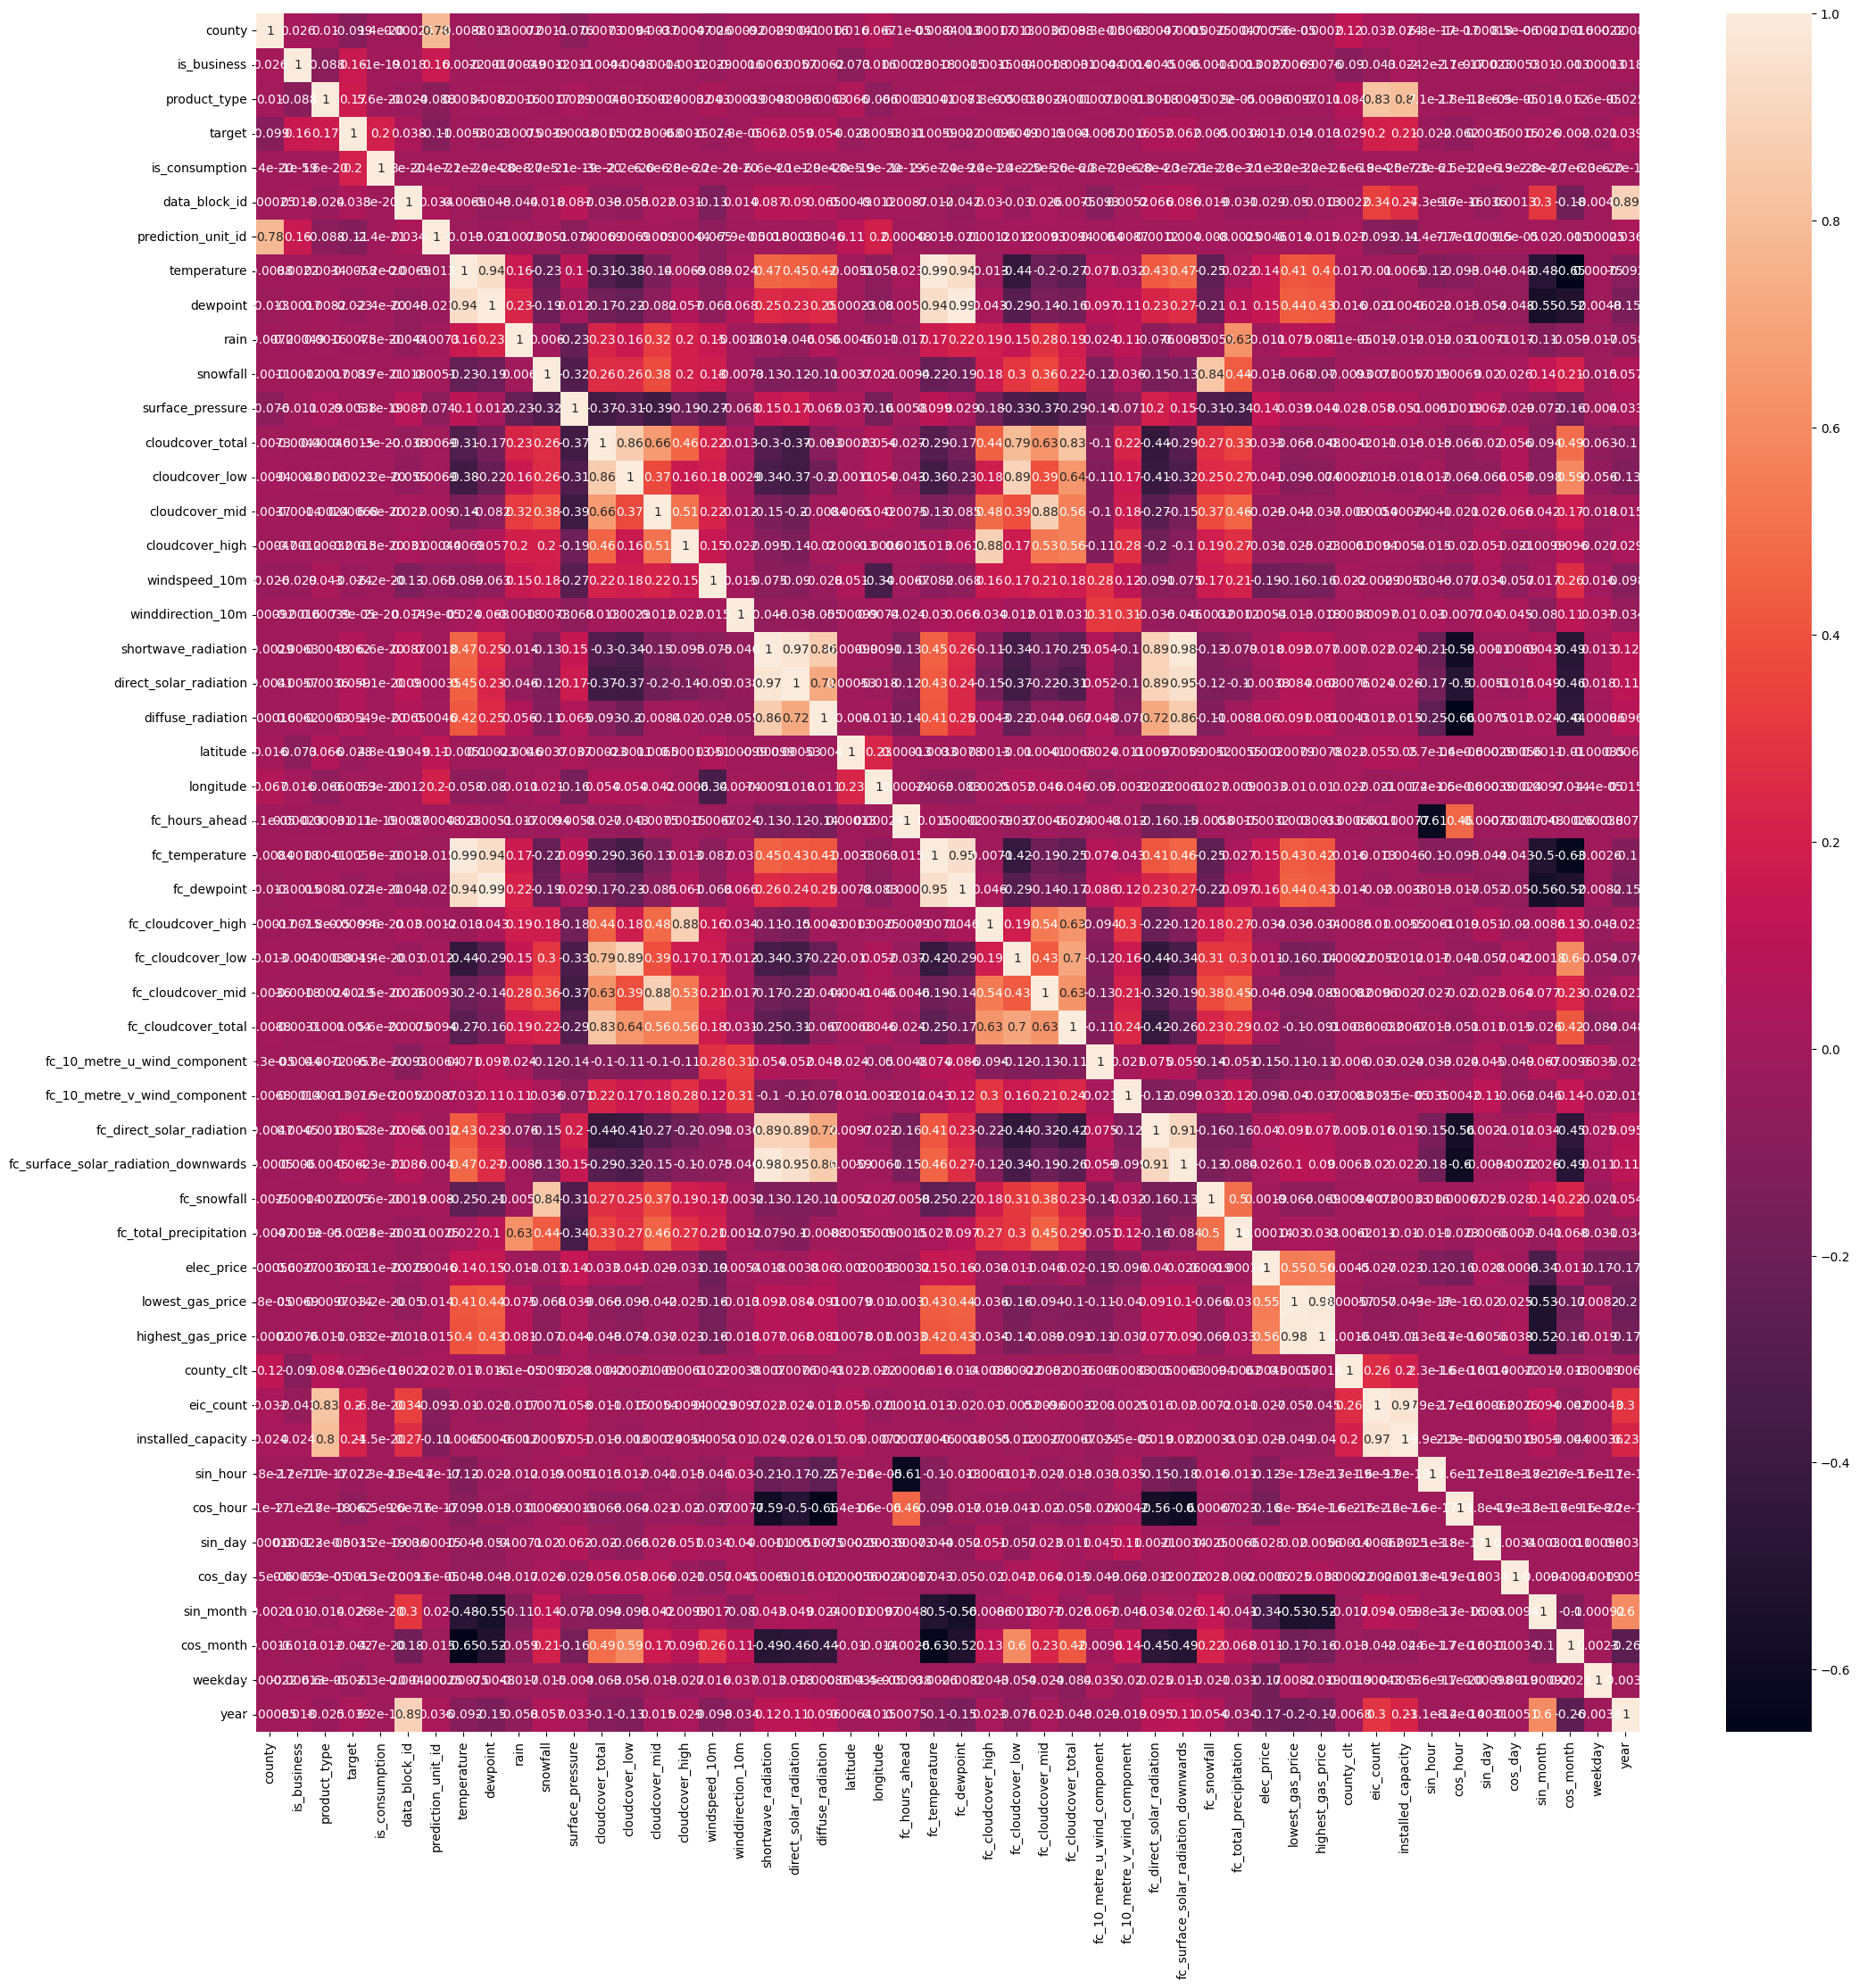

In [239]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(25,25))
train_num = train.select_dtypes(['number'])
sns.heatmap(train_num.corr(), annot=True)

In [234]:
train.isna().sum().sum()

8812124

## Export

In [235]:
train.to_csv("dataset.csv", index=False)